In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score

%matplotlib inline

import seaborn as sns
sns.set(style='whitegrid')
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

import re
import requests
import pandas as pd
import numpy as np
from time import sleep
from bs4 import BeautifulSoup

In [84]:
election_demographic=pd.read_table("training_set.txt", sep=",")

election_demographic['Poverty Estimate, All Ages']=election_demographic['Poverty Estimate, All Ages'].astype(float)
election_demographic['Poverty Percent, All Ages']=election_demographic['Poverty Percent, All Ages'].astype(float)
election_demographic['Poverty Estimate, Age 0-17']=election_demographic['Poverty Estimate, Age 0-17'].astype(float)
election_demographic['Poverty Percent, Age 0-17']=election_demographic['Poverty Percent, Age 0-17'].astype(float)
election_demographic['Poverty Estimate, Age 5-17 in Families']=election_demographic['Poverty Estimate, Age 5-17 in Families'].astype(float)
election_demographic['Poverty Percent, Age 5-17 in Families']=election_demographic['Poverty Percent, Age 5-17 in Families'].astype(float)
election_demographic['Median Household Income']=election_demographic['Median Household Income'].astype(float)
election_demographic['Poverty Estimate, All Ages']=election_demographic['Poverty Estimate, All Ages'].astype(float)

###Added variables: lag response = percentage voted for democrats/republicans in 2012/percentage voted for democrats in 2008 
election_demographic['lag_response_dem']=election_demographic['Democrats 2012']/election_demographic['Democrats 2008']
election_demographic['lag_response_rep']=election_demographic['Republicans 2012']/election_demographic['Republicans 2008']

##Outcome variables: percentage of votes weighted by county population
election_demographic['response_rep']=election_demographic['TOT_POP']*election_demographic['Republicans 2016']
election_demographic['response_dem']=election_demographic['TOT_POP']*election_demographic['Democrats 2016']

display(election_demographic.describe())
print(election_demographic.shape)

##prediction calculation: sum each county by states / population for each state > 0.5 --> republican / democrat 

##Noahs: calculated approx. county adv. Ballots 2016 (calculation)
##Categorical: early_voting, felony_laws, id_law, reg_laws

##TO do: create senate response variable

##Base model: 
##1) decisiion tree base model (train-val split 80-20 split; validation score comparison rep/ dem outcome)
##2) senate prediction base model (subset of financial data to senate but the rest same for presidential)

##Can we weight certain nodes in the tree? 

,FIPS,Precincts,Votes,Democrats 08 (Votes),Democrats 12 (Votes),Republicans 08 (Votes),Republicans 12 (Votes),Republicans 2016,Democrats 2016,Green 2016,Libertarians 2016,Republicans 2012,Republicans 2008,Democrats 2012,Democrats 2008,SUMLEV,YEAR,AGEGRP,TOT_POP,TOT_MALE,TOT_FEMALE,WA_MALE,WA_FEMALE,BA_MALE,BA_FEMALE,IA_MALE,IA_FEMALE,AA_MALE,AA_FEMALE,NA_MALE,NA_FEMALE,TOM_MALE,TOM_FEMALE,WAC_MALE,WAC_FEMALE,BAC_MALE,BAC_FEMALE,IAC_MALE,IAC_FEMALE,AAC_MALE,AAC_FEMALE,NAC_MALE,NAC_FEMALE,NH_MALE,NH_FEMALE,NHWA_MALE,NHWA_FEMALE,NHBA_MALE,NHBA_FEMALE,NHIA_MALE,...,Food services,Health care,Information,Management,Manufacturing,Mining,Other,Professional Services,Real Estate,Recreation,Retail,Transportation,Utitilities,Wholesale,pres_rep_receipts,pres_rep_disburse,pres_rep_cash_on_hand,pres_dem_receipts,pres_dem_disburse,pres_dem_cash_on_hand,senate_rep_receipts,senate_rep_disburse,senate_rep_cash_on_hand,senate_dem_receipts,senate_dem_disburse,senate_dem_cash_on_hand,# of state advanced ballots cast 2012,# of state advanced ballots cast 2016,# votes 2012,# votes 2016,% of state pop 2012,% of state pop 2016,2012 Population,2016 Population,calculated approx. county adv. Ballots 2012,calculated approx. county adv. Ballots 2016,early_voting,felony_laws,id_laws,reg_laws,state population 2012,state population 2016,Democrats 12,Republicans 12,Democrats 08,Republicans 08,lag_response_dem,lag_response_rep,response_rep,response_dem
count,3139.000000,3111.000000,3.111000e+03,3.111000e+03,3.111000e+03,3111.000000,3111.000000,3111.000000,3111.000000,2601.000000,3111.000000,3111.000000,3111.000000,3111.000000,3111.000000,3139.0,3139.0,3139.0,3.139000e+03,3.139000e+03,3.139000e+03,3.139000e+03,3.139000e+03,3139.000000,3139.000000,3139.000000,3139.000000,3139.000000,3139.000000,3139.000000,3139.000000,3139.000000,3139.000000,3.139000e+03,3.139000e+03,3139.000000,3139.000000,3139.000000,3139.000000,3139.000000,3139.000000,3139.000000,3139.000000,3.139000e+03,3.139000e+03,3.139000e+03,3.139000e+03,3139.000000,3139.000000,3139.000000,...,3124.000000,3116.000000,3026.000000,2227.000000,3067.000000,2407.00000,3128.00000,3106.000000,3018.000000,2970.000000,3134.000000,3100.000000,2824.000000,3074.000000,2.614000e+03,2.614000e+03,2.614000e+03,2.614000e+03,2.614000e+03,2.614000e+03,2.199000e+03,2.199000e+03,2.199000e+03,2.199000e+03,2.199000e+03,2.199000e+03,3.139000e+03,3.139000e+03,3.114000e+03,3.114000e+03,3139.000000,3139.000000,3.139000e+03,3.139000e+03,3.139000e+03,3.139000e+03,3138.000000,3138.000000,3138.000000,3138.000000,3.139000e+03,3.139000e+03,3111.000000,3111.000000,3111.000000,3111.000000,3111.000000,3111.000000,3.111000e+03,3.111000e+03
mean,30392.532972,54.927997,4.176518e+04,2.229861e+04,2.114430e+04,19207.495018,19532.239151,63.608655,31.679286,0.874781,3.163017,59.670636,56.812707,38.481760,41.540440,50.0,9.0,0.0,1.028731e+05,5.065636e+04,5.221673e+04,3.922311e+04,3.991419e+04,6554.200064,7134.899968,648.019114,637.028990,2776.347244,3047.128703,123.808538,120.142721,1330.874482,1363.334820,4.040511e+04,4.111825e+04,7138.959860,7749.088245,1059.376234,1069.166932,3268.624403,3540.416693,243.977063,242.008601,4.140983e+04,4.316121e+04,3.107626e+04,3.195168e+04,6126.071360,6690.502071,371.693214,...,1125.816261,1427.878691,238.778916,123.522676,475.234757,55.09140,1204.93766,1447.818738,646.585487,230.942761,1705.130823,372.090323,32.027266,662.187703,2.507656e+07,2.493558e+07,2.682536e+05,1.545457e+07,1.542237e+07,3.627506e+04,1.105800e+07,1.094219e+07,1.271978e+06,8.969606e+06,9.125349e+06,6.120304e+05,1.308732e+06,1.312056e+06,4.129668e+04,4.370150e+04,0.016205,0.016204,9.997415e+04,1.028766e+05,1.468942e+04,1.504227e+04,0.339707,0.718611,1.908859,1.701402,8.465247e+06,8.765933e+06,39.204909,60.795091,42.231932,57.768068,0.914320,1.051450,4.779363e+06,5.061940e+06
std,15156.298611,172.872053,1.134234e+05,7.715204e+04,7.424628e+04,44871.249071,44788.385720,15.619852,15.325975,0.647901,1.518689,14.761418,13.825709,14.764096,13.848301,0.

(3139, 174)


In [85]:
election_demographic.to_csv('train_updated.csv', index=False)

In [101]:
election_demographic.head()

,State,ST,FIPS,County,Precincts,Votes,Democrats 08 (Votes),Democrats 12 (Votes),Republicans 08 (Votes),Republicans 12 (Votes),Republicans 2016,Democrats 2016,Green 2016,Libertarians 2016,Republicans 2012,Republicans 2008,Democrats 2012,Democrats 2008,SUMLEV,YEAR,AGEGRP,TOT_POP,TOT_MALE,TOT_FEMALE,WA_MALE,WA_FEMALE,BA_MALE,BA_FEMALE,IA_MALE,IA_FEMALE,AA_MALE,AA_FEMALE,NA_MALE,NA_FEMALE,TOM_MALE,TOM_FEMALE,WAC_MALE,WAC_FEMALE,BAC_MALE,BAC_FEMALE,IAC_MALE,IAC_FEMALE,AAC_MALE,AAC_FEMALE,NAC_MALE,NAC_FEMALE,NH_MALE,NH_FEMALE,NHWA_MALE,NHWA_FEMALE,...,Food services,Health care,Information,Management,Manufacturing,Mining,Other,Professional Services,Real Estate,Recreation,Retail,Transportation,Utitilities,Wholesale,pres_rep_receipts,pres_rep_disburse,pres_rep_cash_on_hand,pres_dem_receipts,pres_dem_disburse,pres_dem_cash_on_hand,senate_rep_receipts,senate_rep_disburse,senate_rep_cash_on_hand,senate_dem_receipts,senate_dem_disburse,senate_dem_cash_on_hand,# of state advanced ballots cast 2012,# of state advanced ballots cast 2016,# votes 2012,# votes 2016,% of state pop 2012,% of state pop 2016,2012 Population,2016 Population,calculated approx. county adv. Ballots 2012,calculated approx. county adv. Ballots 2016,early_voting,felony_laws,id_laws,reg_laws,state population 2012,state population 2016,Democrats 12,Republicans 12,Democrats 08,Republicans 08,lag_response_dem,lag_response_rep,response_rep,response_dem
0,Alabama,AL,1005,Barbour County,18.0,10390.0,5697.0,5912.0,5866.0,5550.0,52.271415,46.660250,0.173244,0.895091,48.189633,50.438521,51.332812,48.985383,50,9,0,25806,13626,12180,6779,6071,6515,5858,91,60,54,58,28,13,159,120,6897,6176,6622,5929,168,107,69,78,33,18,13004,11689,6272,5665,...,255.0,215.0,25.0,NaN,135.0,20.0,180.0,160.0,100.0,25.0,440.0,145.0,40.0,75.0,205.0,5271.0,0.0,0.0,0.0,0.0,5914160.0,13077935.0,9992806.0,33268.0,32369.0,442.0,0,2399,11509.0,10469.0,0.005642,0.005306,27169,25806,0.0,12.729161,2.0,1.0,3.0,2.0,4815588,4863525,51.579131,48.420869,49.269221,50.730779,1.046883,0.954467,1.348916e+06,1.204114e+06
1,Alabama,AL,1103,Morgan County,42.0,49991.0,13895.0,13439.0,36014.0,35391.0,74.797464,22.436038,0.436078,2.330419,71.556239,71.255589,27.172001,27.491987,50,9,0,119006,58586,60420,48940,50152,7353,7871,669,609,354,461,93,73,1177,1254,50052,51320,7890,8446,1245,1217,509,628,118,116,53272,55978,44185,46234,...,1030.0,1690.0,145.0,70.0,790.0,20.0,1375.0,940.0,500.0,130.0,2355.0,405.0,20.0,810.0,205.0,5271.0,0.0,0.0,0.0,0.0,5914160.0,13077935.0,9992806.0,33268.0,32369.0,442.0,0,2399,49323.0,50644.0,0.024940,0.024469,120102,119006,0.0,58.701332,2.0,1.0,3.0,2.0,4815588,4863525,27.522015,72.477985,27.840670,72.159330,0.988554,1.004416,8.901347e+06,2.670023e+06
2,Alabama,AL,1069,Houston County,29.0,42030.0,12225.0,12367.0,29254.0,29270.0,72.726624,25.093980,0.342612,1.836783,69.717035,70.094645,29.456460,29.291961,50,9,0,104218,50012,54206,35320,37258,12975,15037,251,279,411,595,35,44,1020,993,36237,38129,13523,15566,627,654,605,782,90,112,48208,52631,33865,36022,...,1260.0,1585.0,220.0,115.0,515.0,NaN,1385.0,1055.0,505.0,140.0,2710.0,425.0,30.0,880.0,205.0,5271.0,0.0,0.0,0.0,0.0,5914160.0,13077935.0,9992806.0,33268.0,32369.0,442.0,0,2399,41918.0,42639.0,0.021466,0.021428,103371,104218,0.0,51.406949,2.0,1.0,3.0,2.0,4815588,4863525,29.701948,70.298052,29.472745,70.527255,1.007777,0.996750,7.579423e+06,2.615244e+06
3,Alabama,AL,1087,Macon County,16.0,8748.0,9450.0,9045.0,1396.0,1331.0,15.935071,82.727481,0.548697,0.788752,12.803001,12.834421,87.004617,86.880574,50,9,0,19060,8710,10350,1559,1552,6935,8579,21,29,75,28,2,1,118,161,1647,1675,7006,8666,71,90,99,72,10,17,8535,10197,1471,1492,...,105.0,120.0,15.0,NaN,30.0,10.0,160.0,55.0,25.0,10.0,230.0,40.0,NaN,30.0,205.0,5271.0,0.0,0.0,0.0,0.0,5914160.0,13077935.0,9992806.0,33268.0,32369.0,442.0,0,2399,10394.0,9140.0,0.004279,0.003919,20608,19060,0.0,9.401605,2.0,1.0,3.0,2.0,4815588,4863525,87.172321,12.827679,87.128895,12.871105,1.000498,0.996626,3.037225e+05,1.576786e+06
4

In [43]:
###population: column 26-38 
###education: column 100-104
###unemployment: 108-111
###poverty: 112-119 
###insurance: 120-125 
###CBP: 126-145

train_merge=pd.concat([election_demographic.iloc[:, election_demographic.columns.get_loc('TOT_POP'):election_demographic.columns.get_loc('NA_FEMALE')+1],
                       election_demographic.iloc[:, election_demographic.columns.get_loc('At Least High School Diploma'):election_demographic.columns.get_loc('School Enrollment')+1],
                       election_demographic.loc[:, 'Poverty Estimate, All Ages'],
                       election_demographic.loc[:, 'Median Household Income'],
                       election_demographic.iloc[:, election_demographic.columns.get_loc('NUI'):election_demographic.columns.get_loc('NIC')+1],
                       election_demographic.iloc[:, election_demographic.columns.get_loc('--'):election_demographic.columns.get_loc('Wholesale')+1]
                      ], axis=1)
print(train_merge.shape)
train_cor=train_merge.corr(method="pearson")

(3139, 41)


**Figure 1** Histogram of all 41 demographic variables adding economic uncertainty


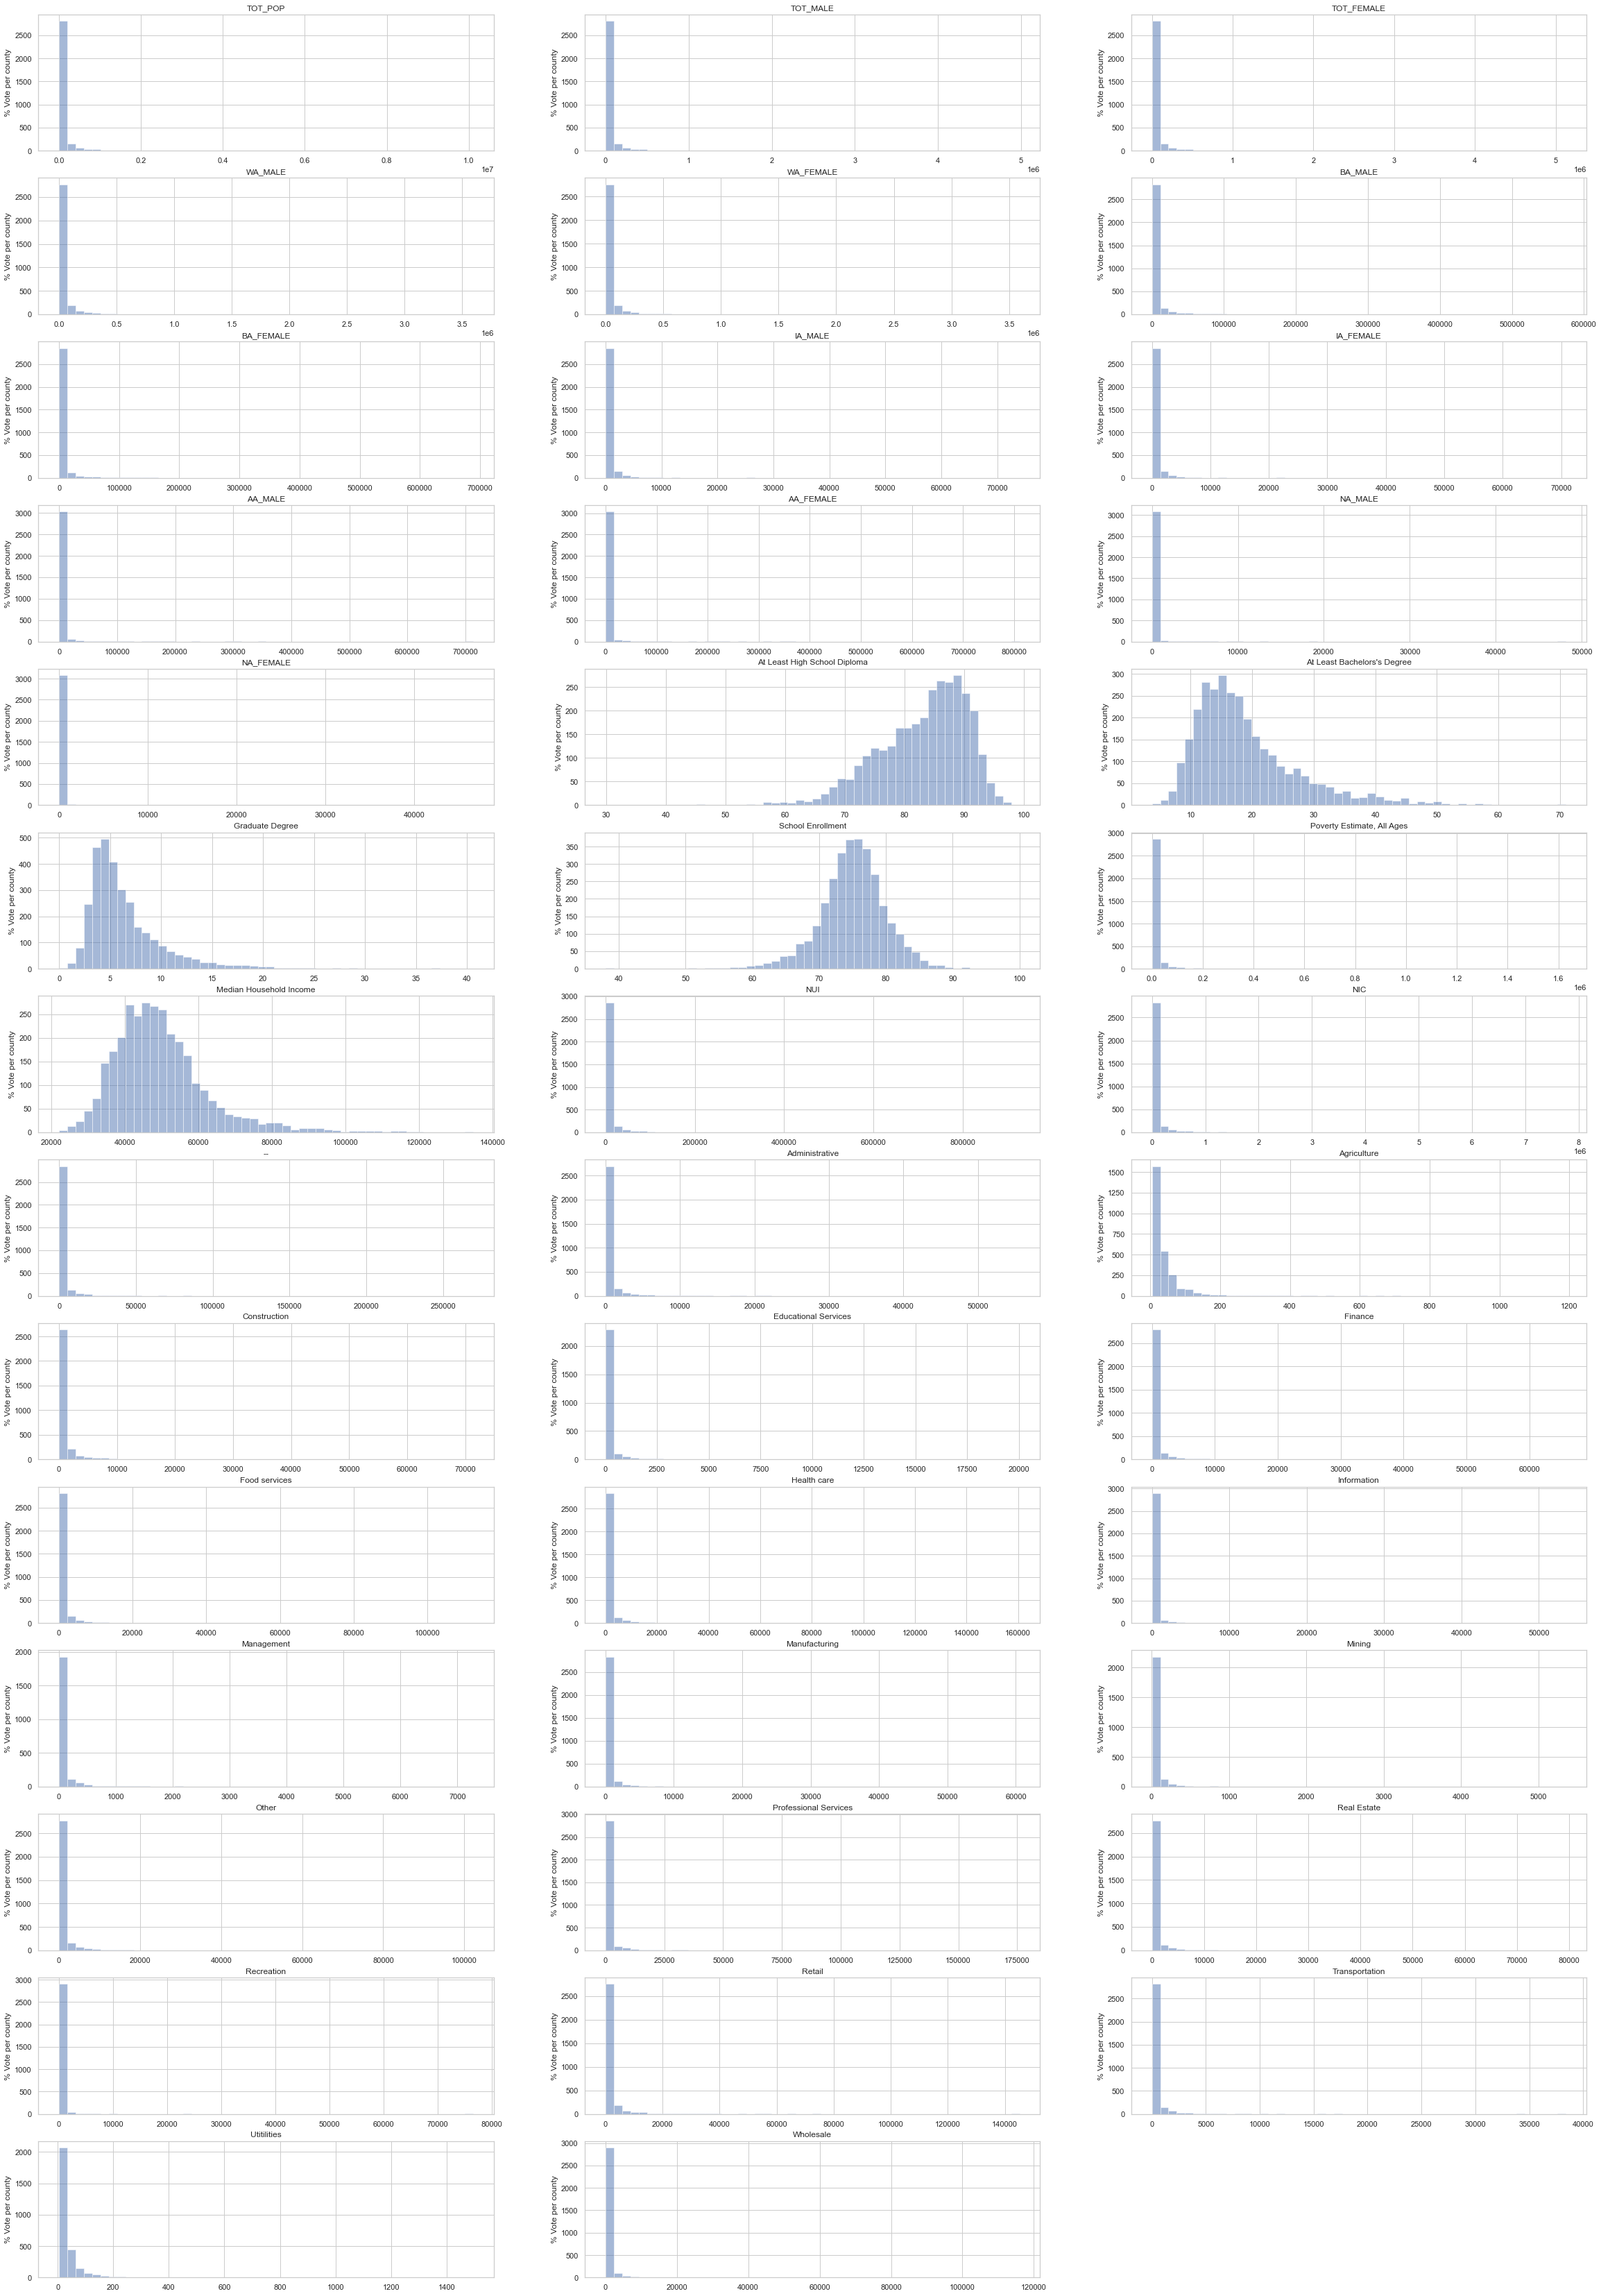

In [76]:
plt.figure(figsize=[40,60])
for i, col in enumerate(train_merge.columns):
    plt.subplot(14, 3, i+1)
    plt.hist(x=((train_merge[col])), bins=50, alpha=0.5)
    plt.ylabel('% Vote per county')
    plt.title(col)
plt.show()

**Figure 2** Heatmap of all 41 demographic variables adding economic uncertainty  


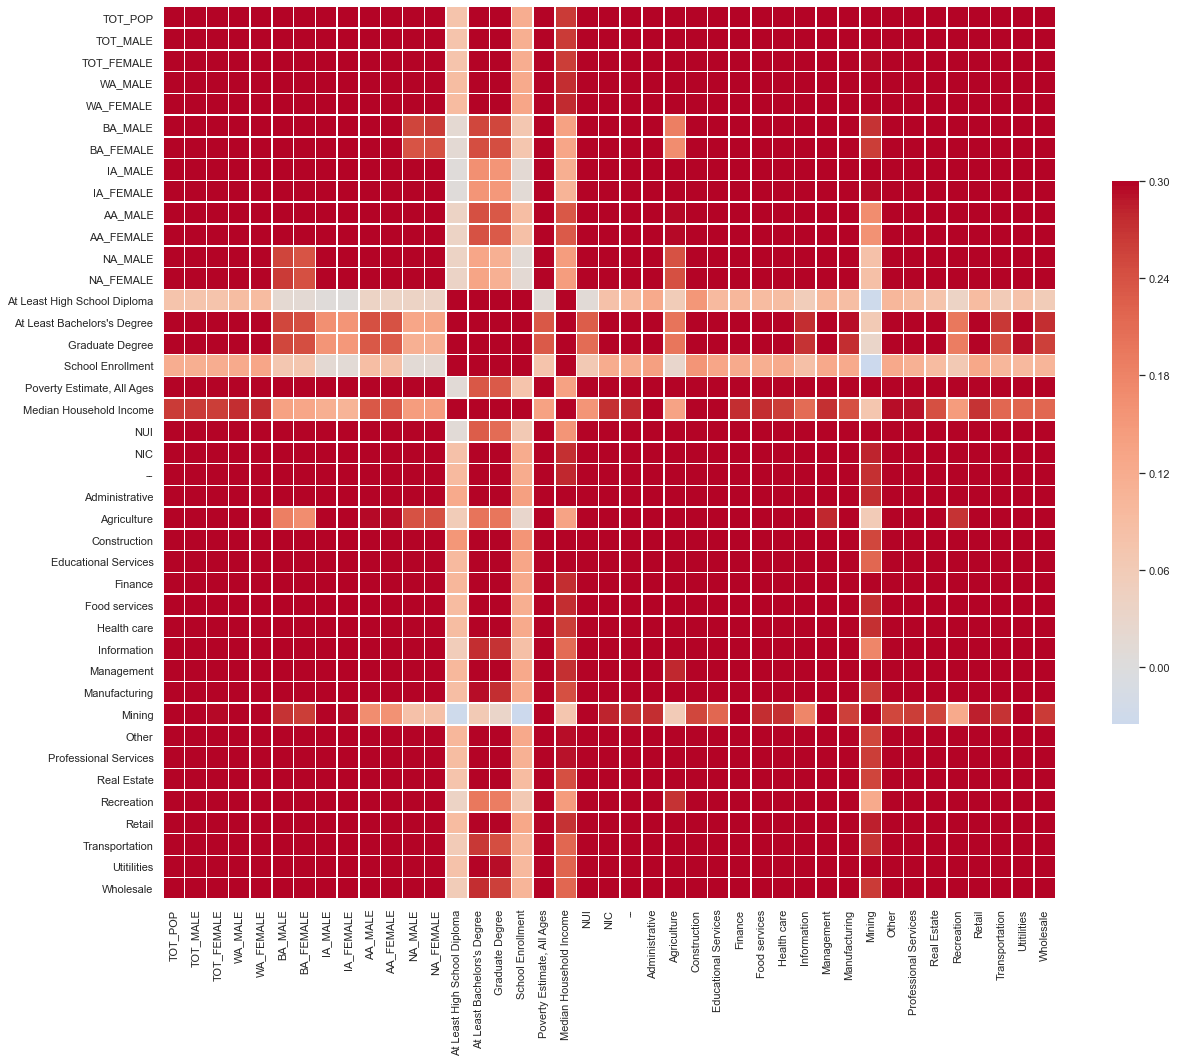

In [46]:
###Heatmap for chosen variables
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(train_cor, cmap="coolwarm",vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

**Figure 3** Scatter plot of all 41 demographic variables adding economic uncertainty against numbers of votes for Democrats and Republicans weighted by county population

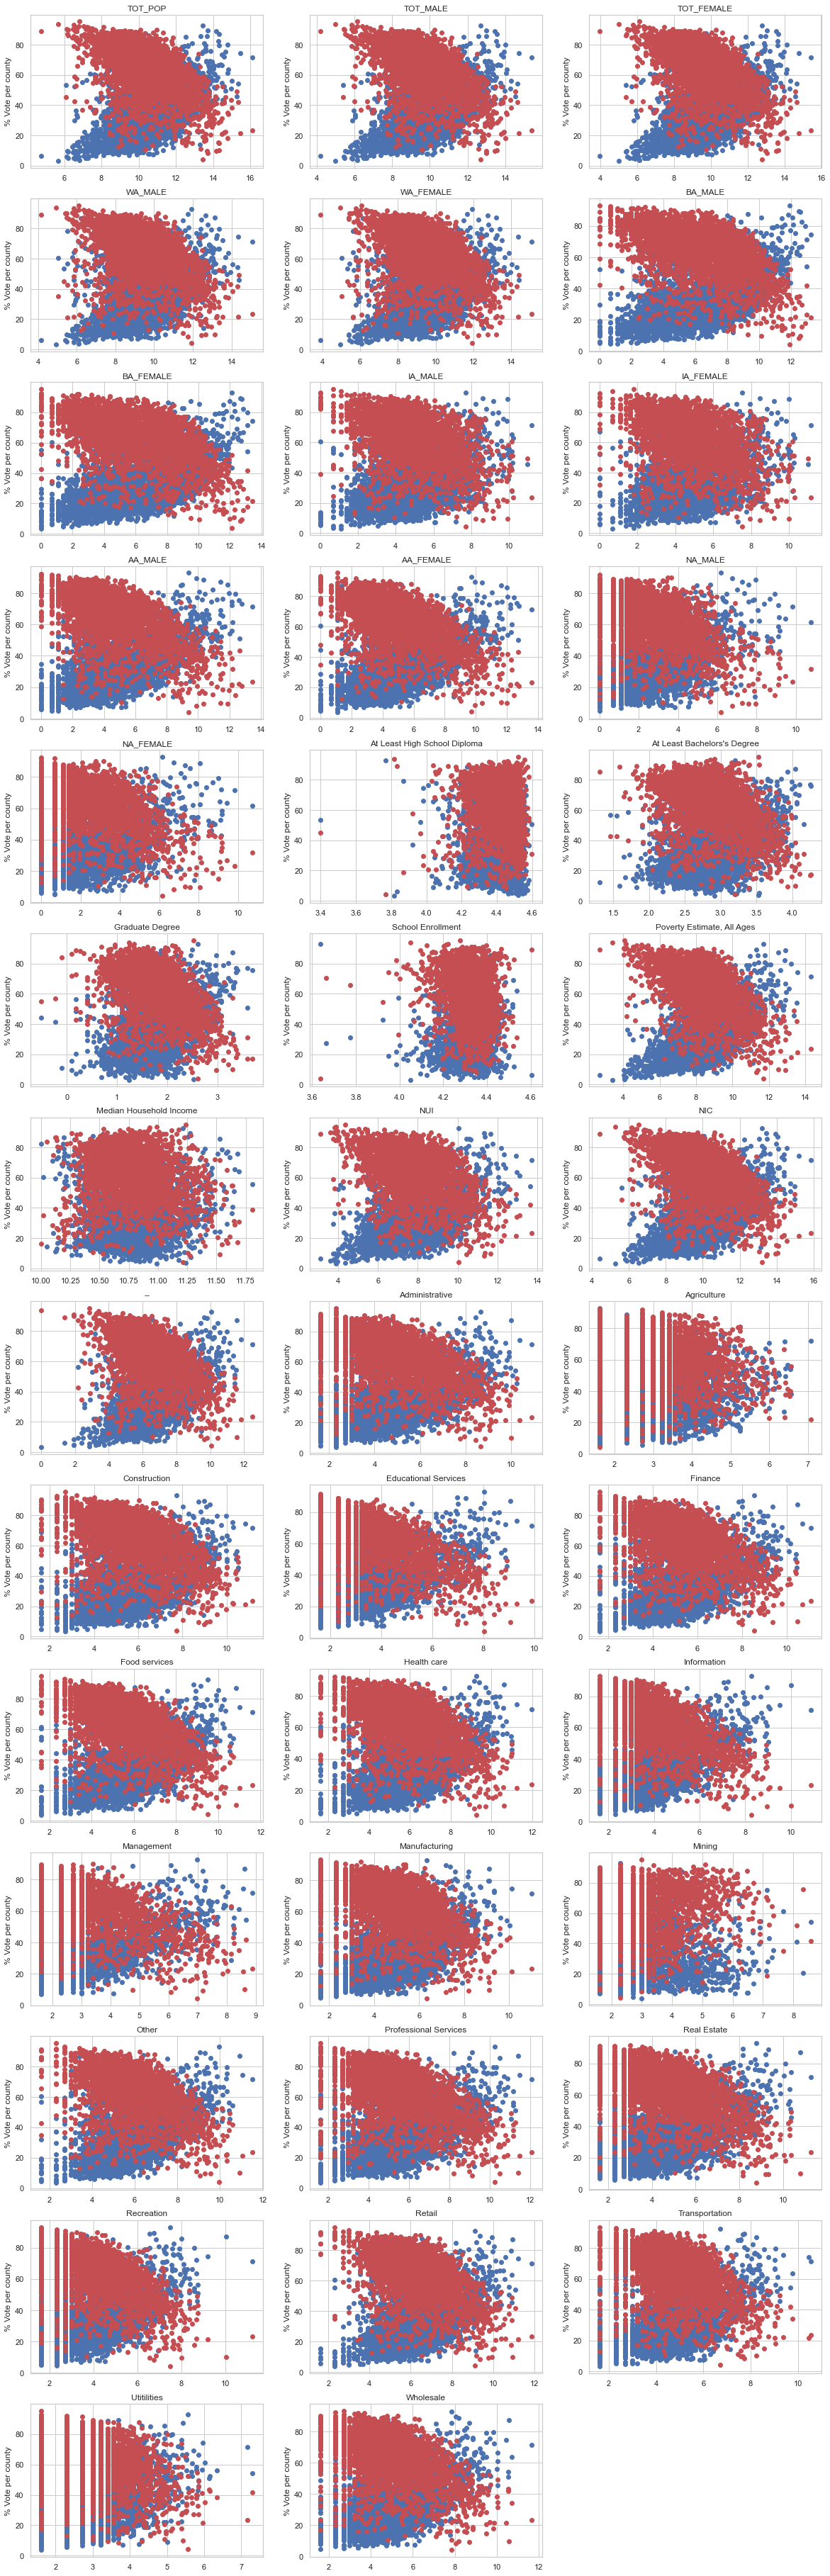

In [80]:
###Regression to election outcome 2016 
plt.figure(figsize=[20,66])

for i, col in enumerate(train_merge.columns):
    plt.subplot(14, 3, i+1)
    plt.scatter(y=election_demographic['Democrats 2016'], x=np.log(train_merge[col]) ,color='b')
    plt.scatter(y=election_demographic['Republicans 2016'], x=np.log(train_merge[col]),color='r' )
    plt.ylabel('% Vote per county')
    plt.title(col)
plt.show()


**Figure 4** Scatter plot of all 41 demographic variables adding economic uncertainty against numbers of votes for Democrats and Republicans weighted by county population

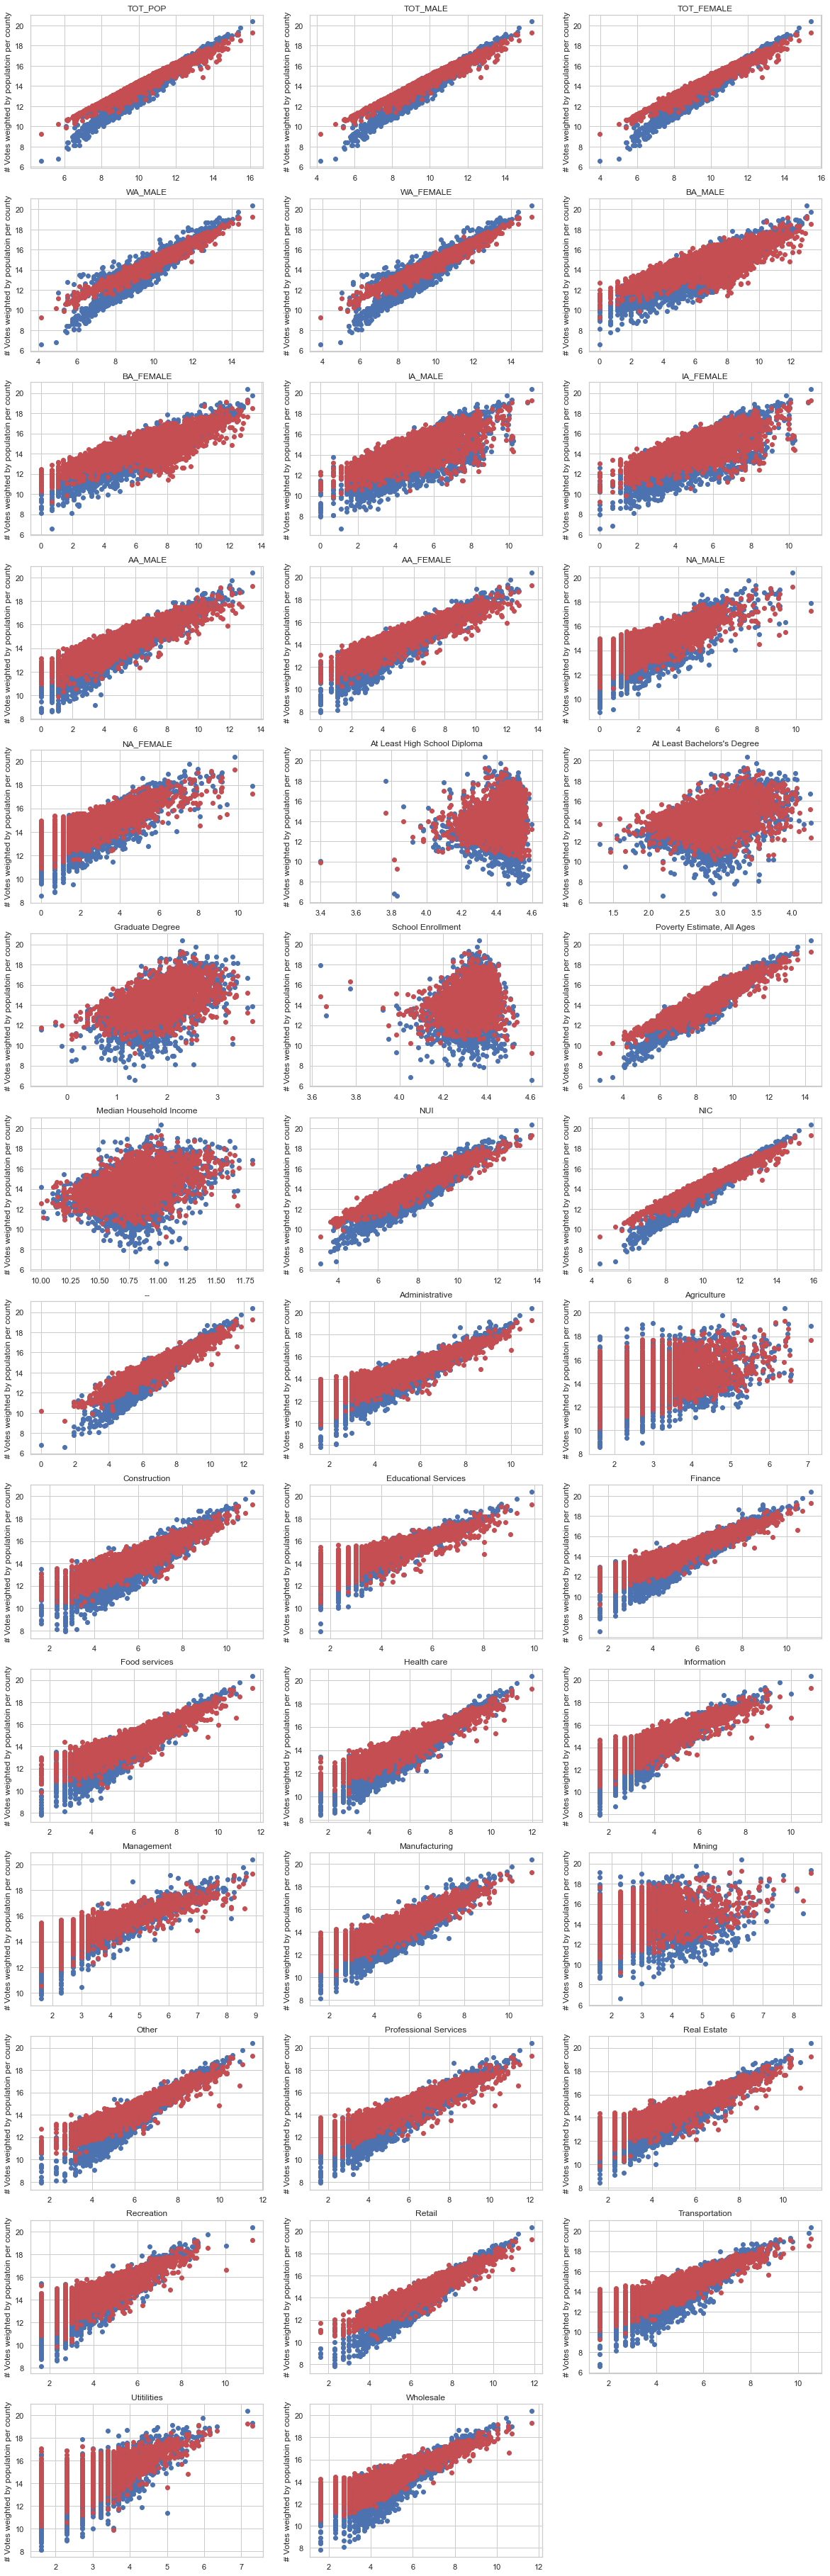

In [236]:
###correlation with # votes weighted by population 

plt.figure(figsize=[20,66])

for i, col in enumerate(train_merge.columns):
    plt.subplot(14, 3, i+1)
    plt.scatter(y=np.log(election_demographic['response_dem']), x=np.log(train_merge[col]) ,color='b')
    plt.scatter(y=np.log(election_demographic['response_rep']), x=np.log(train_merge[col]),color='r' )
    plt.ylabel('# Votes weighted by populatoin per county')
    plt.title(col)
plt.show()

**Figure 5** Heatmap of all 12 financial variables 

(3139, 12)


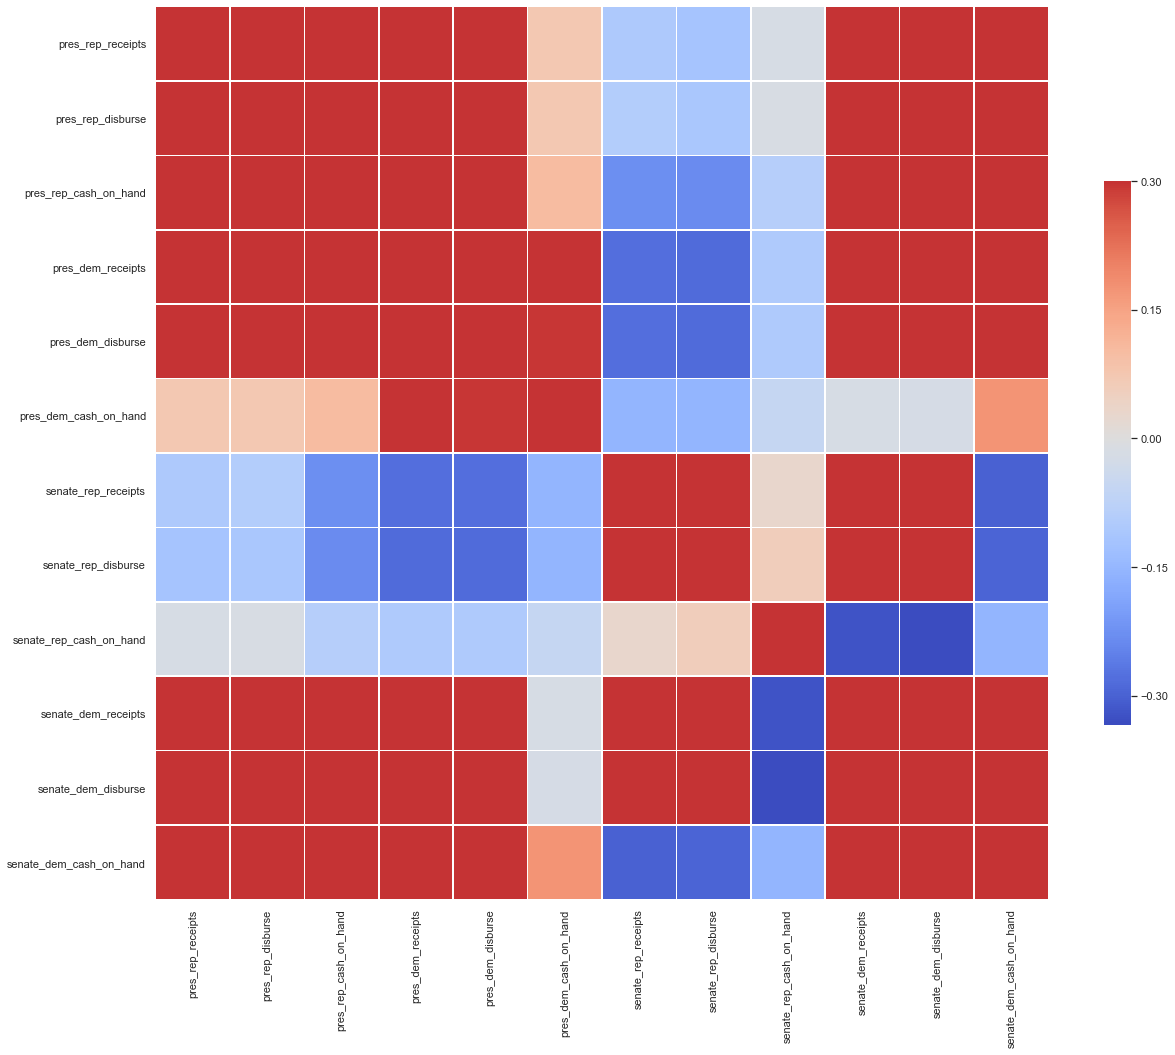

In [77]:
####Finance heatmap 
finance=election_demographic.iloc[:, election_demographic.columns.get_loc('pres_rep_receipts'):election_demographic.columns.get_loc('senate_dem_cash_on_hand')+1]
print(finance.shape)
train_finance_cor=finance.corr(method="pearson")

###Heatmap for chosen variables
f, ax = plt.subplots(figsize=(20, 20))
#cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(train_finance_cor, cmap="coolwarm", vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

**Figure** Scatter plot of all 41 demographic variables against % votes for Democrats and Republicans

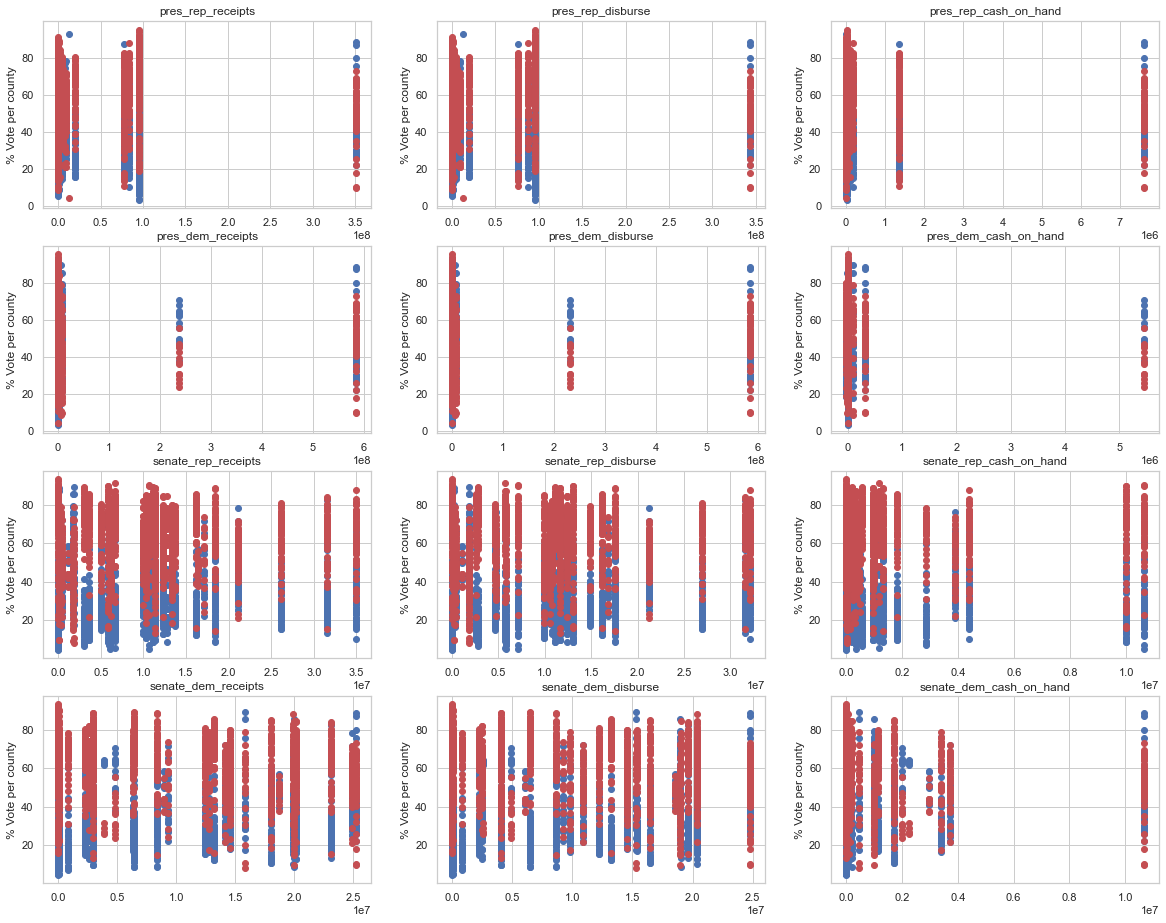

In [81]:
plt.figure(figsize=[20,20])

for i, col in enumerate(finance.columns):
    plt.subplot(5, 3, i+1)
    plt.scatter(y=election_demographic['Democrats 2016'], x=(finance[col]) ,color='b')
    plt.scatter(y=election_demographic['Republicans 2016'], x=(finance[col]),color='r' )
    plt.ylabel('% Vote per county')
    plt.title(col)
plt.show()

**Figure** Scatter plot of all 12 financial variables against numbers of votes for Democrats and Republicans weighted by county population

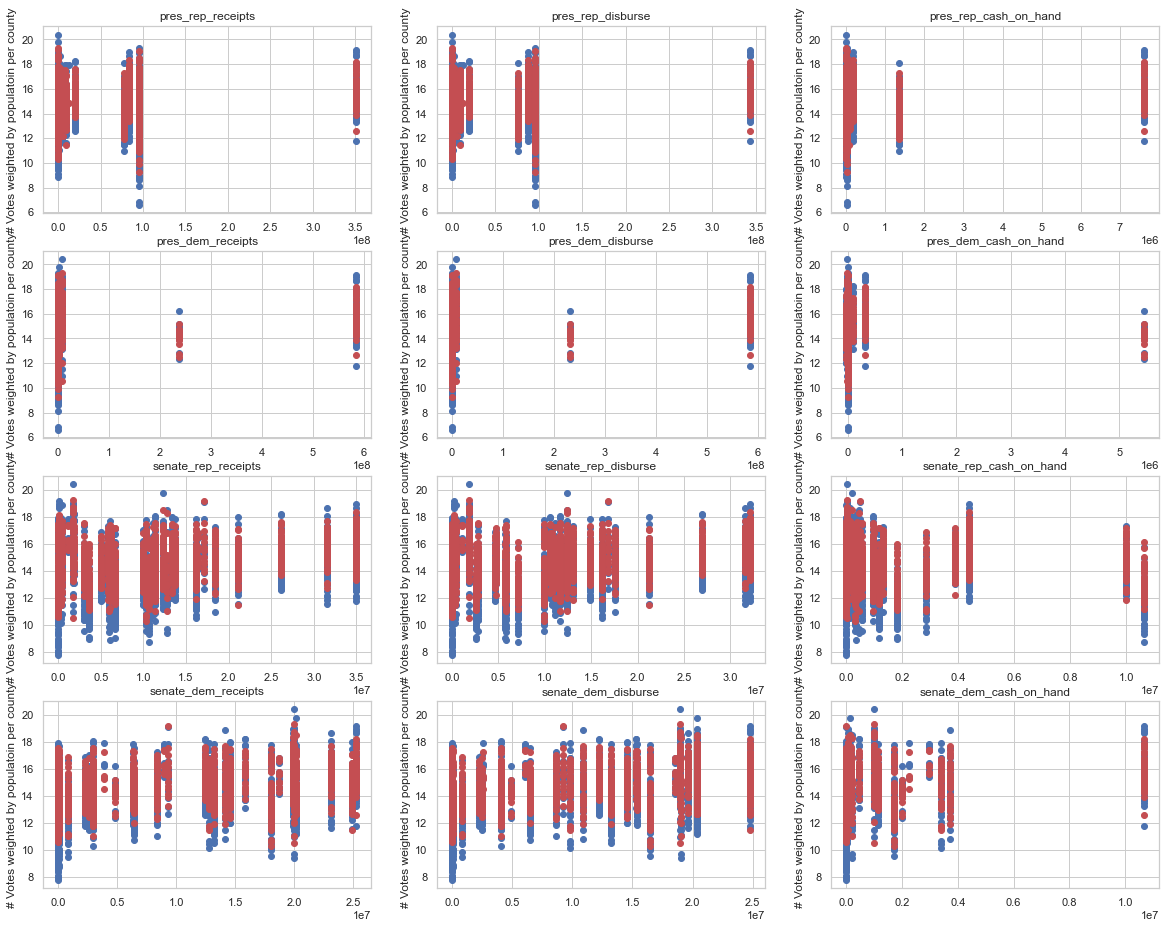

In [238]:
plt.figure(figsize=[20,20])

for i, col in enumerate(finance.columns):
    plt.subplot(5, 3, i+1)
    plt.scatter(y=np.log(election_demographic['response_dem']), x=(finance[col]) ,color='b')
    plt.scatter(y=np.log(election_demographic['response_rep']), x=(finance[col]),color='r' )
    plt.ylabel('# Votes weighted by populatoin per county')
    plt.title(col)
plt.show()

**Figure** Heatmap of base demographics adding economic uncertainty and financial data 

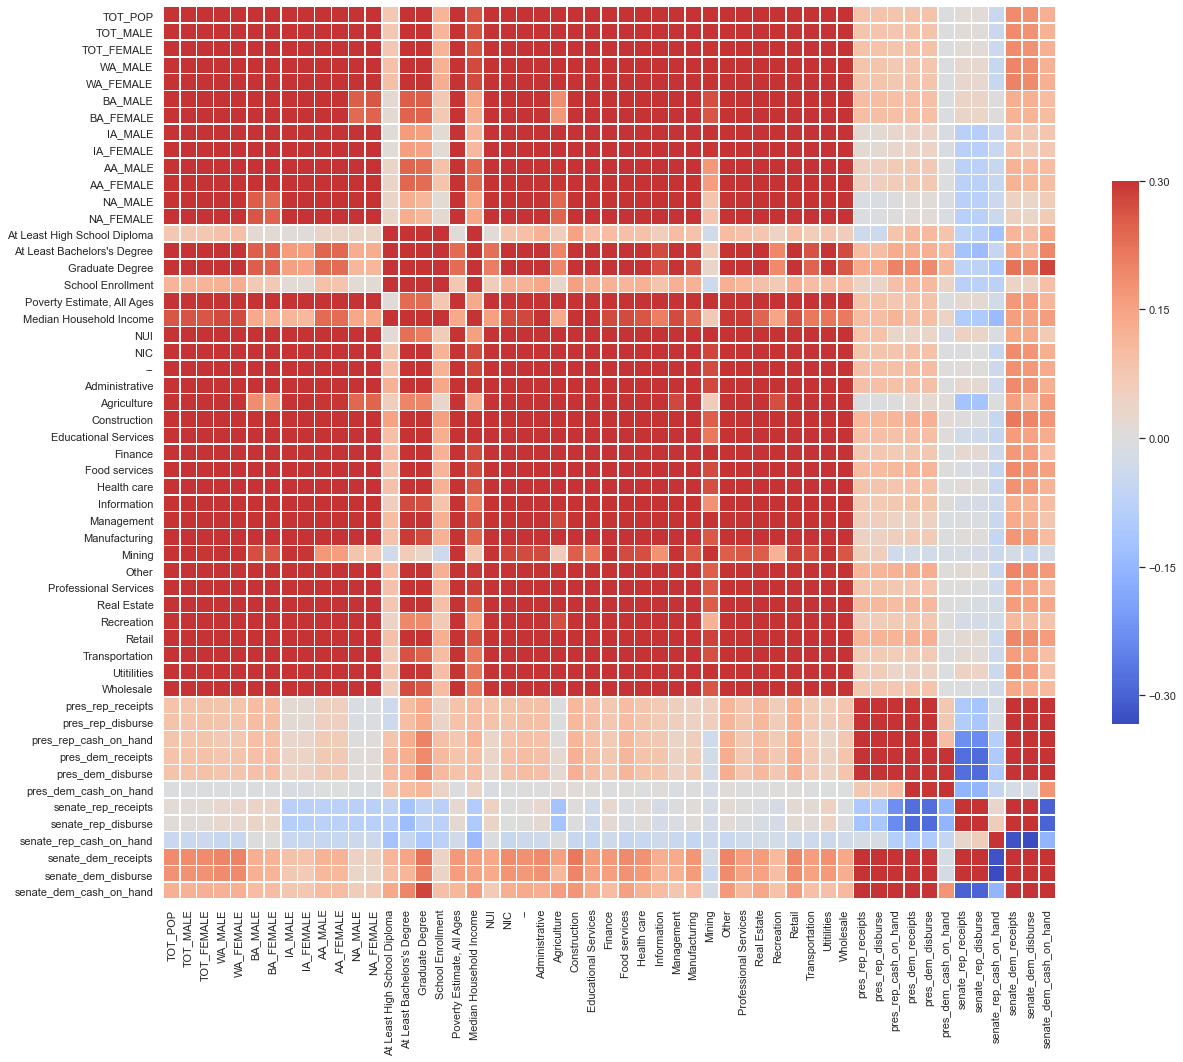

In [78]:
base_fianance_merge=pd.concat([train_merge,finance],axis=1)
base_fianance_merge_cor=base_fianance_merge.corr(method="pearson")

###Heatmap for chosen variables
f, ax = plt.subplots(figsize=(20, 20))
#cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(base_fianance_merge_cor, cmap="coolwarm", vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()


**Figure**  Histograms of % votes for Republicans and Democrats per county 

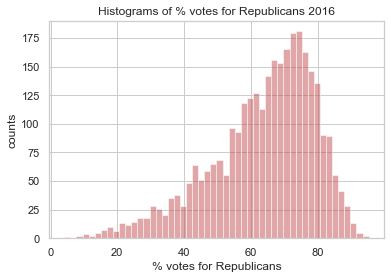

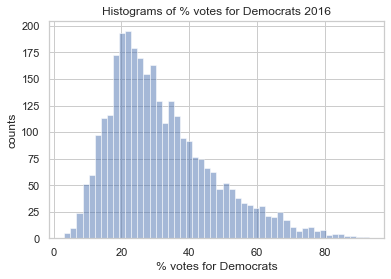

In [229]:
###EDA for outcome variables - % votes 

plt.hist(x=((election_demographic['Republicans 2016'])), bins=50, alpha=0.5, color='r')
plt.title("Histograms of % votes for Republicans 2016")
plt.xlabel("% votes for Republicans")
plt.ylabel("counts")
plt.show()

plt.hist(x=((election_demographic['Democrats 2016'])), bins=50, alpha=0.5, color='b')
plt.xlabel("% votes for Democrats")
plt.ylabel("counts")
plt.title("Histograms of % votes for Democrats 2016")
plt.show()


**Figure** Histograms of numbers of votes weighted by county population for Republicans and Democrats per county 

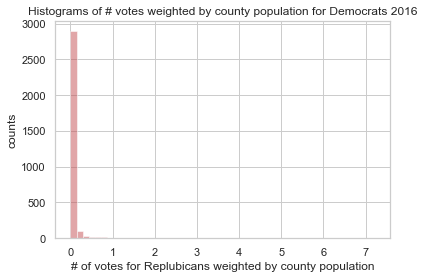

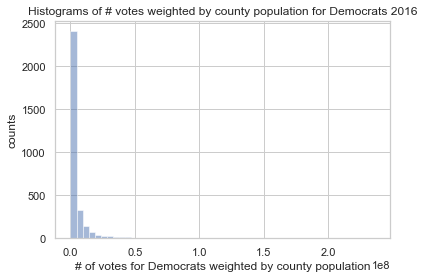

In [233]:
plt.hist(x=((election_demographic['response_dem'])), bins=50, alpha=0.5, color='r')
plt.xlabel("# of votes for Replubicans weighted by county population")
plt.ylabel("counts")
plt.title("Histograms of # votes weighted by county population for Democrats 2016")
plt.show()

plt.hist(x=((election_demographic['response_rep'])), bins=50, alpha=0.5,color='b')
plt.xlabel("# of votes for Democrats weighted by county population")
plt.ylabel("counts")
plt.title("Histograms of # votes weighted by county population for Democrats 2016")
plt.show()

**Figure** Histograms of log-transformed numbers of votes weighted by county population for Republicans and Democrats per county 

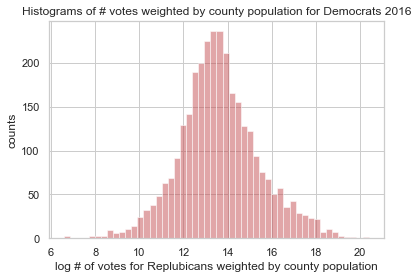

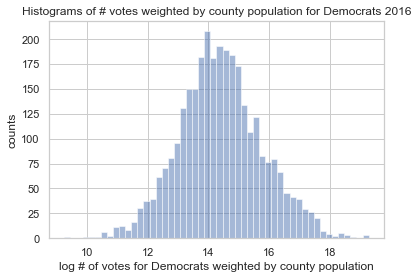

In [228]:
###EDA for outcome variables - # votes 

plt.hist(x=(np.log(election_demographic['response_dem'])), bins=50, alpha=0.5, color='r')
plt.xlabel("log # of votes for Replubicans weighted by county population")
plt.ylabel("counts")
plt.title("Histograms of # votes weighted by county population for Democrats 2016")
plt.show()

plt.hist(x=(np.log(election_demographic['response_rep'])), bins=50, alpha=0.5,color='b')
plt.xlabel("log # of votes for Democrats weighted by county population")
plt.ylabel("counts")
plt.title("Histograms of # votes weighted by county population for Democrats 2016")
plt.show()